# Exercise: Create your own AI image generator

In this exercise, you will create your own AI image generator. You will take the famous MNIST dataset and train a Variational Auto Encoder that will generate new images of handwritten digits.

Let's get started!

In [2]:
# https://download.pytorch.org/whl/torch_stable.html 
! pip install torch torchvision matplotlib > /dev/null

In [3]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)



In [4]:
# Define a VAE
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

        self.z_dim = z_dim
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=4)

# set device

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [5]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=4, bias=True)
  (fc32): Linear(in_features=256, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [6]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    # Reconstruction error. To measure how well we have reconstructed the input image.
    # See https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL divergence. To measure how closely the latent variables match a unit Gaussian distribution.
    # See the original paper ("Auto-Encoding Variational Bayes")[https://arxiv.org/abs/1312.6114]
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + KLD # total loss

In [7]:
def train(epoch):
    vae.train() # set model to training mode
    train_loss = 0

    # iterate over the training data
    for batch_idx, (data, _) in enumerate(train_loader):

        data = data.to(device) # move data to device
        optimizer.zero_grad() # clear the gradients of all optimized variables
        
        output_images, mu, log_var = vae(data) # forward pass
        loss = loss_function(output_images, data, mu, log_var) # calculate loss
        
        loss.backward() # backward pass
        train_loss += loss.item() # update running training loss
        optimizer.step() # perform a single optimization step (parameter update)
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} '
                  f'[{batch_idx * len(data)}/{len(train_loader.dataset)} {100. * batch_idx / len(train_loader):.0f}] '
                  f'Loss: {loss.item() / len(data):.6f}'
                  )
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

In [8]:
# def test():
#     vae.eval()
#     test_loss= 0
#     with torch.no_grad():
#         for data, _ in test_loader:
#             # data = data.cuda()
#             recon, mu, log_var = vae(data)
            
#             # sum up batch loss
#             test_loss += loss_function(recon, data, mu, log_var).item()
        
#     test_loss /= len(test_loader.dataset)
#     print('====> Test set loss: {:.4f}'.format(test_loss))

In [9]:
! rm -rf gen_mnist_img && mkdir -p gen_mnist_img

z = torch.randn(16, vae.z_dim).to(device)

def write_gen_mnist_img(z, vae, epoch):
    with torch.no_grad():
        z_decoded = vae.decoder(z).to(device)

    filename = f'./gen_mnist_img/epoch_{epoch}.png'   
    print(f"Writing {filename}")
    save_image(z_decoded.view(16, 1, 28, 28), filename)

for epoch in range(6):
    if epoch % 3 == 0:
        write_gen_mnist_img(z, vae, epoch)

    train(epoch)

write_gen_mnist_img(z, vae, epoch)


Writing ./gen_mnist_img/epoch_0.png
Train Epoch: 0 [0/60000 0] Loss: 545.308437
Train Epoch: 0 [10000/60000 17] Loss: 189.488945
Train Epoch: 0 [20000/60000 33] Loss: 176.446406
Train Epoch: 0 [30000/60000 50] Loss: 153.893203
Train Epoch: 0 [40000/60000 67] Loss: 150.795557
Train Epoch: 0 [50000/60000 83] Loss: 146.693564
====> Epoch: 0 Average loss: 168.2435
Train Epoch: 1 [0/60000 0] Loss: 136.302158
Train Epoch: 1 [10000/60000 17] Loss: 140.435225
Train Epoch: 1 [20000/60000 33] Loss: 142.276133
Train Epoch: 1 [30000/60000 50] Loss: 129.222168
Train Epoch: 1 [40000/60000 67] Loss: 136.789414
Train Epoch: 1 [50000/60000 83] Loss: 143.516592
====> Epoch: 1 Average loss: 137.6516
Train Epoch: 2 [0/60000 0] Loss: 141.526230
Train Epoch: 2 [10000/60000 17] Loss: 141.485195
Train Epoch: 2 [20000/60000 33] Loss: 127.308711
Train Epoch: 2 [30000/60000 50] Loss: 131.170654
Train Epoch: 2 [40000/60000 67] Loss: 136.123809
Train Epoch: 2 [50000/60000 83] Loss: 134.451367
====> Epoch: 2 Averag

epoch_0.png


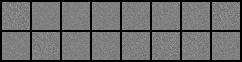

epoch_3.png


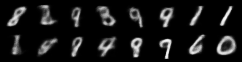

epoch_5.png


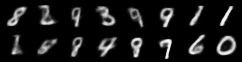

In [10]:
# for each image in the directory gen_mnist_img, show the image
from IPython.display import Image, display
import matplotlib.pyplot as plt
import os

filenames = sorted(os.listdir('./gen_mnist_img'))

for filename in filenames:
    print("=========================================")
    print(filename)
    display(Image('./gen_mnist_img/' + filename))
    plt.show()


In [11]:
# Each of the 16 digits is generated by a different 4 dimensional vector. Here
# the variable z is a 16x4 matrix. Each row of z generates a single handwritten digit.
z

tensor([[-0.1755, -0.7560,  1.2792,  1.3944],
        [ 0.2064,  0.0617, -0.9806,  0.1840],
        [ 0.8846, -0.5556, -0.2331, -0.6110],
        [ 0.9311,  0.7514, -1.1772, -0.1154],
        [ 0.6720,  0.7672, -1.4230, -1.0333],
        [ 0.9499, -0.2068,  0.9084, -0.6871],
        [-0.0882, -1.2655,  0.0735,  0.7786],
        [-0.2273, -1.8494, -0.1172,  1.0577],
        [-0.0347, -0.6089, -1.0442,  0.2008],
        [-1.1780, -0.4097,  1.4066,  0.5232],
        [ 0.6507, -0.9194,  0.5041, -0.0575],
        [-0.0973, -0.2457,  1.1008, -0.2390],
        [ 1.7148, -0.4770,  0.6148, -0.6918],
        [ 0.7487, -0.4712,  0.1091, -2.5654],
        [-1.2931, -0.3248, -0.4960,  1.5480],
        [-0.8799,  1.2432,  0.0752,  0.6455]])

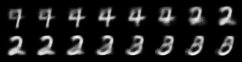

In [12]:
# Let's explore the space of z a little more. First, let's handcraft
# vectors that should exhibit a smooth transition in the output space

z = torch.tensor(
    [
        [ 0.0000,  0.0000,  0.0000,  -1.400],
        [ 0.0000,  0.0000,  0.0000,  -1.200],
        [ 0.0000,  0.0000,  0.0000,  -1.000],
        [ 0.0000,  0.0000,  0.0000,  -0.800],
        [ 0.0000,  0.0000,  0.0000,  -0.600],
        [ 0.0000,  0.0000,  0.0000,  -0.400],
        [ 0.0000,  0.0000,  0.0000,  -0.200],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.2000],
        [ 0.0000,  0.0000,  0.0000,  0.4000],
        [ 0.0000,  0.0000,  0.0000,  0.6000],
        [ 0.0000,  0.0000,  0.0000,  0.8000],
        [ 0.0000,  0.0000,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  1.2000],
        [ 0.0000,  0.0000,  0.0000,  1.4000],
        [ 0.0000,  0.0000,  0.0000,  1.6000],
    ]
)

# Then generate a handwritten digit from that vector.
z_decoded = vae.decoder(z).to(device)

filename = "smooth transtion 1.png"
save_image(z_decoded.view(16, 1, 28, 28), filename)
display(Image(filename))


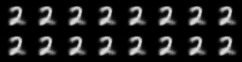

In [13]:
# Now try putting in your own numbers below. How many different digits can you 
# smoothly transition between?

z = torch.tensor(
    [
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
    ]
)

# Then generate a handwritten digit from that vector.
z_decoded = vae.decoder(z).to(device)

filename = "smooth transtion 2.png"
save_image(z_decoded.view(16, 1, 28, 28), filename)
display(Image(filename))
